In [1]:
##### Visual String Pot
# This program takes an image and finds the centre of an orange stripe and green dot. It then use the length of the orange stripe to scale the difference between the clusters to calculate the length.
# it uses FAISS kmeans clustering to find a cluster of the approximate size of the stripe and dot.
# the stripe and dot are then rotated onto the principle component of the stripe
# the user defines a reduction and enchancment factotor which reduces the numbe rof pixcel and enchances the colours when the images are imported.
# the uses then defines the window to focus clustering and the aprox dimensions of the striope and dot
# the results are then exported as a csv with index, fileName, timeStamp, measurement, dotMedian, stripeMedian, scale, dotLength,

In [2]:
#### In version 1.1
# image correction and scaling simplified
# plotting impoved
# hyperparmter entry streamlined
# post calibration, offset and scaling
# improved layout to add option for other clustering methods later

In [3]:
# define functions

def loadImages(directory, file_list, sample, reduction, enchanced, dim, ench_type):
    ## Function takes file list and  if samples --> loads sample,
    # otherwise loads all images in file list, reducing by the reduction factor and enchancing by the enchance factor.
    # If dim --> crops image otherwise entire image is loaded

    timeStamp = []  # create empty list for time stamps
    index = 0  # set index to zero, used as counter for assignment  to array

    if not sample:  # if sample does not exist create a list of numbers to load
        sample = range(len(file_list))  # make sample the entire file list

    if not dim:  # open an image and get the image dimensions if no cropping is supplied
        image = np.array(Image.open(directory + file_list[0]).reduce(int((reduction))))  # load image to array
        h, w, d = tuple(image.shape)  # get shape of image in file
        dim = [0, h, 0, w, ]  # assign shape to dim list so entire image is imported

    # Create empty NP array for pixcels. All pictures are loaded into an array height, width, # images, colours
    pixcels = np.empty((dim[1] - dim[0],  # number of rows
                        dim[3] - dim[2],  # number of columns
                        len(sample),  # number of images
                        3),  # number of colour arrays per image + 3 for x and y and l
                       dtype='float32')

    for sam in sample:  # loop over each file in file_list
        clear_output(wait=True)  # clear output
        file = file_list[sam]  # set file as the sam'th entry in file list
        file_path = directory + file  # define file path
        ts = Image.open(file_path)._getexif()[36867]  # import timestamp as tS

        if enchanced:  # if an enchancments is call
            #open image and create enchancer
            if ench_type == 'Bright':
                enchancer = ImageEnhance.Brightness(Image.open(file_path).reduce(int((reduction))))
                image = np.array(enchancer.enhance(enchanced))  # load image and convert to array

            else:
                enchancer = ImageEnhance.Contrast(Image.open(file_path).reduce(int((reduction))))
                image = np.array(enchancer.enhance(enchanced))  # load image and convert to array

        else:  # if no enchancement is called
            image = np.array(Image.open(file_path).reduce(int((reduction))))  # load image into array
        # crop array and load into pixcels array
        pixcels[:, :, index, :] = image[dim[0]: dim[1],
                                  dim[2]: dim[3],
                                  :]

        timeStamp.append(ts)  # append time stamp to list
        index += 1
        print("importing " + file + " file # " + str(sam + 1) + " of " + str(len(file_list) + 1))
        print(ts)
    return (timeStamp, pixcels)

def determine_enchancement(in_dir, file_list, sample, reduction, enchancement, dim, ench_type, target_length):
    avgLength = 0
    while avgLength < target_length:
        timeStamp, pixcels = loadImages(in_dir, file_list, sample, reduction, enchancement, dim, ench_type)
        avgLength = np.reshape(pixcels, (-1,3))
        lengths = []
        for i in range(0,avgLength.shape[0]):
            lengths.append(np.linalg.norm(avgLength[i]))
        avgLength = sum(lengths)/len(lengths)

        if avgLength < target_length:
            enchancement += 1

    return enchancement

def clus2Image(clussArr, centers, recolour_dict, scale):
    ## defien function to take an array of cluster labels and centers and return an image array, with specified clusters recoulured if required
    if scale:
        Scaler = MinMaxScaler(feature_range=(0,255)) # define minmax scaler to scale colours to 0 --> 255
        centers = Scaler.fit_transform(centers)

    if recolour_dict: # if recolour provided
        for key in recolour_dict.keys(): # iterate over each key value pair
            centers[key] = np.asarray(recolour_dict[key]) # change the value of that center to the specified colour

    imgArr = centers[clussArr]

    return(imgArr)

def plotSamples(imgArray, ticks, title, titleData, scaleColours):
    ## function takes either an image array or array of cluster labels. checks if colours are valid and if required changes colour of selected clusters.
    # Then plots images over 2 columns and as many rows as required. user selects if ticks and headings --> supply heading data in list form

    if scaleColours: # if scaling colours is required
        Scaler = MinMaxScaler(feature_range=(0,255)) # define minmax scaller to scale colours to 0 --> 255
        imgArray = Scaler.fit_transform(imgArray) # scale image array RGB channels


    sampleSize = imgArray.shape[2]  # return the 3rd dimension of the array as the number of images to plot
    width = 2  # set number of columns to plot
    height = int(sampleSize / width)  # determine how many rows to plot
    index = 0  # set a counter to 0
    plt.close()  # close previous plot
    f, axarr = plt.subplots(height, width)  # create enough rows to plot all samples
    for row in range(0, height):  # iterate over each image row
        for h in range(0, height):  # iterare over each column
            axarr[h, row].imshow(imgArray[:, :, index, :].astype('uint8'))  # open image and plot
            if title:
                axarr[h, row].title.set_text(titleData[row])

            if not ticks:
                axarr[h, row].set_xticks([])
                axarr[h, row].set_yticks([])

            index += 1  # increase counter by 1

def faissCluster(pixcels, frac, startClus, noIt, reduction):
    ## define function to perfrom kmeans clustering using faiss
    no_clusters = startClus  # set inital number of clusters
    no_iterations = noIt  # set the no of iterations for each step of kmeans
    clusterMin = 1000  # set cluster min to enter while loop
    restart = 0
    pixcels = np.reshape(pixcels, (h*w*l,-1)) # reshape pixcels to a list of features
    d = pixcels.shape[1] # record the length of each feature to for faiss clustering definition

    if pixcels.dtype != 'float32': # check pixcel data type is suitable for faiss
        pixcels = pixcels.astype('float32') # if required change data type
        print("input array data type changed to "+str(pixcels.dtype)) # print conformation that data type change

    while clusterMin > frac:  # continue to increase number of clusters until the smallest cluster becomes sufficently small to just be the stripe
        #clear_output(wait=True)  # clear output
        print('clustering with ' + str(no_clusters) + "\n")
        kmeans = faiss.Kmeans(d, no_clusters, niter=no_iterations, verbose=True)  # define faiss kmeans object
        kmeans.train(pixcels)  # train kmeans object
        D, I = kmeans.index.search(pixcels, 1)  # return kmeans
        pixInClus = np.unique(I, return_counts=True)  # get counts # pixels in each cluster
        #colour = np.where(pixInClus[1] == min(pixInClus[1])) # assigns the smallest cluster as the stripe colour
        colour = np.where(
            abs(pixInClus[1] / pixInClus[1].sum() - frac) == abs(pixInClus[1] / pixInClus[1].sum() - frac).min())
        clusterMin = min(pixInClus[1]) / (
                    h * w * l)  # Calcultes the fraction of the picture occupied the the stripeColour
        no_clusters += 1  # Increase number of clusters by 1

        if clusterMin < 0.5 * frac: # check if cluster min is signifigantly smaller than the expected fraction
            frac = 1.15 * frac # increase fraction so clustering stops slighly earlier to stop the last step being too large
            no_clusters = startClus # restart the number of clusters
            clusterMin = 1000 # restart cluster min to restart while loop

        print("Cluster Min was " + str(clusterMin) + "\n") # print what the cluster min was

    I = np.reshape(I, (h,w,l,1))

    return (I, kmeans, colour[0])

def get_colour_cosine(kmeans, target_colour): # defien function to inspect all cluster centers and determine which has the clossestr cosine distance to the target colour
    cosineDistance = [] # empty list to store cosine distances

    for i in range(0,kmeans.centroids.shape[0]): # iterate over each centroid
        cosineDistance.append(distance.cosine(kmeans.centroids[i,:], target_colour)) # append the cosine distance to target colour

    trgCluster = np.where(cosineDistance == min(cosineDistance)) # find the closest
    trgCluster = trgCluster[0] # return single row of array for easy handling

    return trgCluster

def norm_to_target(labels, imgArray, trgClus, trg): # define function to normalise each image so as the target clusters appear similar for each image
    noStripe = 0

    imgArray = np.reshape(imgArray,(-1,l,3), order='F') # reshape fortran style so as each photo is a list of vectors

    ## find stripe mean and the picture mean
    if trg:
        labels = np.reshape(labels,(-1,l), order='F') # reshape labels fortran style so as each image is a list of labels
        picMeans_orig = [] # create empy list to append each picture mean
        for i in range(0,l): # iterate over each picture
            if np.where(labels[:,i] == trgClus)[0].shape[0] > 10: # check image contains atleast 10 stripe pixcels
                picMean = list(imgArray[np.where(labels[:,i] == trgClus),i,:].mean(axis=0)[0]) # if 10 stripe pixcel is found  calculate the mean value of the pixcels that are in stripe for that image
                picMeans_orig.append(picMean) # append this mean to pic mean

            else: # if no stripe pixcels are found append the avergae of the previous photo
                picMeans_orig.append(picMean)
                print("used Last pic mean "+str(picMean)+" for image number "+str(i))
                noStripe +=1

        picMeans_orig = np.array(picMeans_orig) # make picMeans_orig an array
        stripe_mean = picMeans_orig.mean(axis=0) # calculate stripe means by finding the average of pic means
        meanModifer = np.subtract(np.transpose(np.reshape(np.tile(stripe_mean, l),(3,l), order='F')),picMeans_orig) # determine the mean modifier

        for i in range(0,l): # iterate over each image
            imgArray[:,i,:] = np.transpose(np.transpose(imgArray[:,i,:])+np.reshape(np.repeat(meanModifer[i,:], h*w, axis=0), (d,h*w))) # apply the mean modifier

    imgArray[np.where(imgArray < 0)] = 0 # find anywhere the the rgb has gone below 0 and replace with 0
    imgArray = np.reshape(imgArray,(h*w*l,d)) # reshape img array to list of pixcels
    pixcelSums = imgArray.sum(axis=1) # find the sum of each pixcel
    pixcelSums[np.where(pixcelSums == 0)] = 1 # where the pixcel sum is 0 replace with 1 to avoid dev by 0 error, it wont matter as 0/1 = 0
    pixcelSums = np.reshape(np.tile(pixcelSums,3), (h*w*l,d), order='F') # reshape to correct shape
    imgArray = np.divide(imgArray, pixcelSums) # normalise by dividing by sum
    imgArray = np.reshape(np.reshape(imgArray,(h*w,l,d)), (h,w,l,d), order='F') # reshape to hand back to

    return imgArray, noStripe

def cleanIQR(upper, lower, singleValues, inplace, verb):
    iqr = np.subtract(*np.percentile(singleValues, [75, 25]))
    med = np.percentile(singleValues, 50)
    minus = np.percentile(singleValues, 25) - lower * iqr
    plus = np.percentile(singleValues, 75) + upper * iqr
    toKeep = (minus < singleValues) & (singleValues < plus)
    if verb:
        plt.close()
        f, axarr = plt.subplots(2)  # create enough rows to plot all samples
        axarr[0].boxplot(singleValues)
        axarr[1].boxplot(singleValues[(minus < singleValues) & (singleValues < plus)])
        print('The min projected y value before cleaning is ' + str(singleValues.min()))
        print('The max projected y value before cleaning is ' + str(singleValues.max()))
        print('The min projected y value after cleaning is ' +
              str(singleValues[(minus < singleValues) & (singleValues < plus)].min()))
        print('The max projected y value after cleaning is ' +
              str(singleValues[(minus < singleValues) & (singleValues < plus)].max()))

    if inplace:
        return (singleValues[(minus < singleValues) & (singleValues < plus)])
    else:
        return (toKeep)

def find_rotation(coords):
    perpClean_min = 1.5
    perpClean_max = 1.5
    rotClean_min = 1.5
    rotClean_max = 1.5
    n=0
    while n < 2:
        pca = PCA(2) #define pca
        pca.fit(coords[0:2,:].T) # fit pca to the stripe cordinates
        Vh = pca.components_ # find rotation vector
        stripe_perp = coords[0:2,:].T @ Vh[:,1] # rotate stripe onto second principle component of stripe to clean
        stripe_perp = cleanIQR(perpClean_max,perpClean_min,stripe_perp, False, True) # remove outliers from stripe rot
        stripe_rot = coords[0:2,:].T @ Vh[:,0] # rotate stripe onto first principle component
        stripe_rot = stripe_rot[stripe_perp]
        coords = coords[:, stripe_perp]
        stripe_rot = cleanIQR(rotClean_max,rotClean_min,stripe_rot, False, True) # clean IQR
        coords = coords[:,stripe_rot]
        n += 1

    print("Stripe is roated "+str(math.acos(Vh[0,0]))+" degrees")
    return(Vh, coords)

def cluster_length(coordinates, Vh):
    imgNo = []
    start_list = []
    stop_list = []
    length_list = []
    prob_list = []
    start_grad = []
    stop_grad = []
    fail = []
    for i in range(0,l):
        clear_output(wait=True)
        print("calculating cluster length for image #"+str(i)+"of"+str(l))
        try:
            
            pic = coordinates[0:2,np.where(coordinates[2,:] == i)[0]] # select from single photo
            pic = np.transpose(np.matmul(np.transpose(pic), Vh)) # transpose and mulitiply by rotation matrix
            pic = abs(np.rint(pic[0,:]).astype('int')) # round and multiply by negative 1
            count = np.bincount(pic) # count how many occourences for each x value
            start = np.where(np.diff(count) == np.diff(count).max())[0][0]
            stop = np.where(np.diff(count) == np.diff(count).min())[0][0]
            length = stop - start
            m = count.max() # assume the highest count is actually the full stripe
            prob = count / m # calculate the probability of each x observation actually being a stripe
            stripeProb = prob[start:stop].sum()/len(prob[start:stop])
            
            start_list.append(start)
            stop_list.append(stop)
            prob_list.append(stripeProb)
            length_list.append(length)
            start_grad.append(np.diff(count)[np.where(np.diff(count) == np.diff(count).max())[0][0]])
            stop_grad.append(np.diff(count)[np.where(np.diff(count) == np.diff(count).min())[0][0]])
            imgNo.append(i)

        except:
            start_list.append(float("nan"))
            stop_list.append(float("nan"))
            prob_list.append(float("nan"))
            length_list.append(float("nan"))
            start_grad.append(float("nan"))
            stop_grad.append(float("nan"))
            imgNo.append(i)
            
    percentileLimit = np.nanpercentile(np.array(prob_list), 95)
    goodSample = np.where(np.array(prob_list) > percentileLimit)
    lengths = np.asarray(length_list)
    clusLength = np.median(lengths[goodSample])
    
    return imgNo, start_list, stop_list, length_list, prob_list, start_grad, stop_grad, clusLength

def getMiddle(stats_df, length, label):
    length_logical = stats_df.length > 0.9 * length
    probs_logical = stats_df.probability > 0.9
    start_logical = abs(stats_df.startGrad) / abs(stats_df.stopGrad) > 0.75
    stop_logical = abs(stats_df.stopGrad) / abs(stats_df.startGrad) > 0.75
    stats_df['useMean'] = list(map(all, zip(length_logical,probs_logical, start_logical, stop_logical)))
    mid = []
    for index, row in stats_df.iterrows():
        if row['useMean']:
            mid.append((row['start']+row['stop'])/2)
        else:
            if abs(row['startGrad']) > abs(row['stopGrad']):
                mid.append(row['start']+ 0.5 * length)
            else:
                mid.append(row['stop']- 0.5 * length)

    stats_df[label] = mid
    
    return(stats_df)

def addInd(w, h, l, pixcels, prince, Vh):
    pixcels = np.reshape(pixcels, (h*w*l,d))
    ## define function to add x and y cordinated, projected onto second principle component of the stripe to the pixcels array so as geometric position has an effect
    i, j, p = np.meshgrid(range(w), range(h), range(l))  # use mesh grid to create arrays of indices
    i = np.reshape(i, (w * h * l, 1)).astype('float32')  # reshape x ind to match reshaped pixcels
    j = np.reshape(j, (w * h * l, 1)).astype('float32')  # reshape y ind to suit reshaped pixcels
    searchArray = np.hstack((j, i))  # stack ontop
    del i
    del j
    del p
    if prince:  # only if using Vh
        searchArray = searchArray @ Vh[:, 1]  # multiply by rotation vector
        plt.close()
        plt.boxplot(searchArray)  # plot to check range
        searchArray = np.interp(searchArray, (searchArray.min(), searchArray.max()), (-1, 1))
        print('scaled min of dot_search is ' + str(searchArray.min()))
        print('scaled max of dot_search is ' + str(searchArray.max()))

    else:  # if no rotation matrix is specified note - this carries both x and y through. if wanting to drop x simply defien a straight rotation matrix
        plt.close()
        plt.boxplot(searchArray)  # plot to check range
        searchArray = np.interp(searchArray, (searchArray.min(), searchArray.max()), (-1, 1))
        print('scaled min of dot_search is ' + str(searchArray.min()))
        print('scaled max of dot_search is ' + str(searchArray.max()))
    searchArray = np.reshape(searchArray, (h * w * l, 1))
    searchArray = np.hstack((pixcels, searchArray))
    ## where is the y component dropped if not using Vh make it carry through
    return (searchArray.astype('float32'))

def GetStats(stripe_loc, perpClean_min, perpClean_max, rotClean_min, rotClean_max):
    pca = PCA(2)  # define scikitLearn PCA function
    pca.fit(stripe_loc[0:2, :].T)  # perform PCA on the x and y componets of the stripe loctions
    Vh = pca.components_  # extract the rotation matrix
    stripe_perp = stripe_loc[0:2, :].T @ Vh[:, 1]  # rotate stripe onto second principle component of stripe to clean
    stripe_perp = cleanIQR(perpClean_max, perpClean_min, stripe_perp, False, False)  # remove outliers from stripe rot
    stripe_rot = stripe_loc[0:2, :].T @ Vh[:, 0]  # rotate stripe onto first principle component
    stripe_rot = stripe_rot[stripe_perp]  # remove values which are removed in the perp cleaning process
    stripe_rot = cleanIQR(rotClean_max, rotClean_min, stripe_rot, True, False)
    ## do i need to shape stripe_perp? and stripe Rot to subset stripe Loc
    stripe_loc = stripe_loc[stripe_perp]  # remove perp outliers from stripe loc
    stripe_loc = stripe_loc[stripe_rot]  # remove rot outliers from loc
    stripeMedian = np.median(stripe_rot)  # find median of the stripe
    stripe_len = (
        abs(abs(np.min(stripe_rot)) - abs(np.max(stripe_rot))))  # finds the abs range of the stripe (known length)

    return (stripeMedian, stripe_len, Vh, stripe_loc)


In [4]:
## Import packages and set up environemnt
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
from IPython.display import clear_output
import time
import faiss

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from scipy.spatial import distance
from scipy.fft import fft, fftfreq, ifft

import math

import seaborn as sns

In [5]:
## define working directory and which files to sample
in_dir = '/mnt/veeringDL_storage/test_9/' # define directory containing all gopro images
out_dir = '/mnt/home/9.0 Data Jobs/' # define output directory
file_list = [f for f in listdir(in_dir) if isfile(join(in_dir, f))] # inspect directory and return list of files
print(str(len(file_list))+' Images found in folder')

10272 Images found in folder


In [6]:
## user defines which images to sample, trget size, enchancemt factor and type
sample = [10,4000,7000,10000] # Set which 4 images to sample
targetSize = 1200000 # define target size in pixcels
enchancement = 1 # define enchancement value
ench_type = 'Bright' # define enchancement type

importing G0023199.JPG file # 10001 of 10273
2022:04:23 14:58:44


<IPython.core.display.Javascript object>


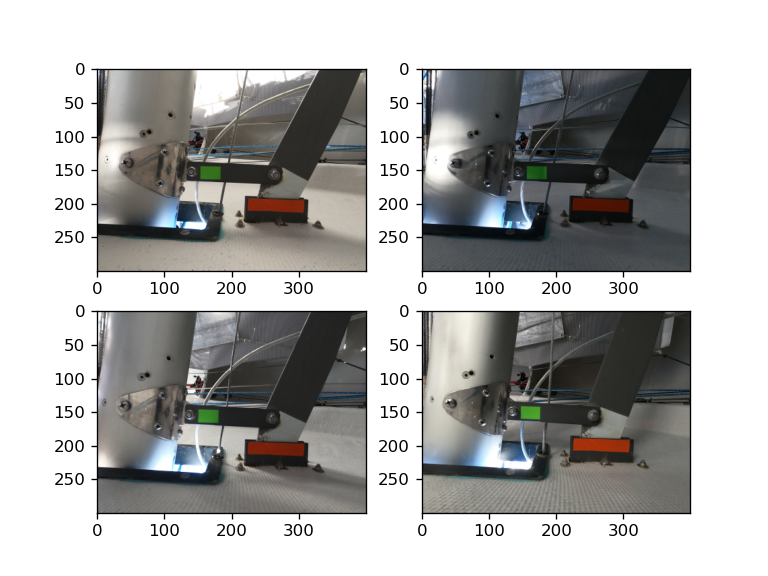

In [7]:
## load sample images and plot
timeStamp, pixcels = loadImages(in_dir, file_list, [0], 1, False, False, False) # load a single image at full resolution
h, w, l, d = orig_shape = tuple(pixcels.shape) # return the dimensions of the original image
reduction = int((h*w)/targetSize) # caclulate the required reduction
print('A reduction factor of '+str(reduction)+' was adopted')
timeStamp, pixcels = loadImages(in_dir, file_list, sample, reduction, enchancement, False, ench_type)
plotSamples(pixcels, True, False, False, False)

importing G0023199.JPG file # 10001 of 10273
2022:04:23 14:58:44
Brightness used 2


<IPython.core.display.Javascript object>


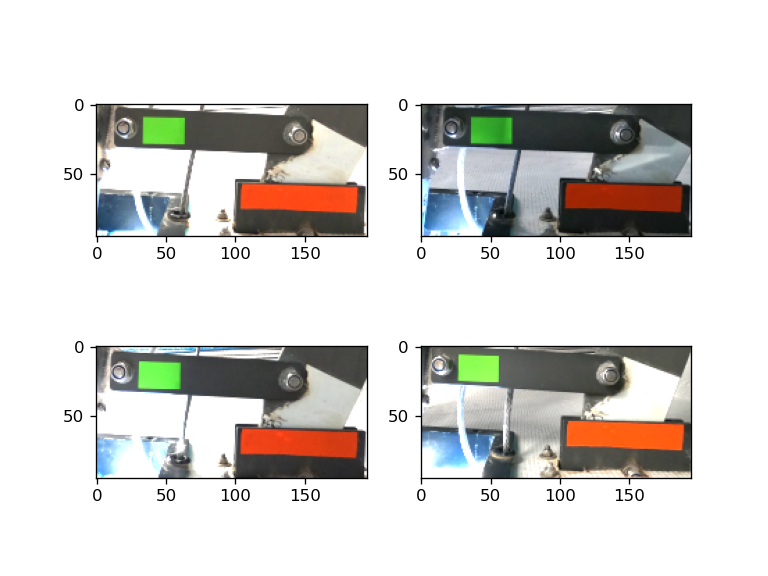

In [9]:
## User defines where to crop image
h1 = 120 # horizontal (x) to start image at
h2 = 315 # horizontal (x) to end image at
v1 = 135 # vertical (y) to start image at
v2 = 230 # vertical (y) to end image at
dim = [v1, v2, h1, h2] # make dim variable as list to pass to load images
enchancement = 1 # define enchancement value
ench_type = 'Bright' # define enchancement type
enchancement_value = determine_enchancement(in_dir, file_list, sample, reduction, enchancement, dim, ench_type, 200)
timeStamp, pixcels = loadImages(in_dir, file_list, sample, reduction, enchancement_value, dim, ench_type)
print("Brightness used "+str(enchancement_value))
plotSamples(pixcels, True, False, False, False)

In [11]:
stripe_left = 106 # left bound of stripe
stripe_right = 189 # right bound of stripe
stripe_top = 65 # top bound of stripe
stripe_bottom = 83 # bottom bound of stripe
dot_left = 32 # left bound dot
dot_right =62 # right bound of dot
dot_top =13 # top bound of dot
dot_bottom = 33 # bottom bound of dot
area_factor = 1.1 # factor to multiply aproximmated area by
stepAfterStripeCluss = 1
stripe_area = abs(stripe_right - stripe_left) * abs(stripe_bottom - stripe_top) # calcluate area of stripe in pixcels
dot_area = abs(dot_right - dot_left) * abs(dot_bottom - dot_top) # calculate area of dot in pixcels
fig_area = abs(v2-v1) * abs(h2-h1) # calculate area of figure with
stripeFrac = area_factor * stripe_area / fig_area # expected fraction of image to be the stripe
dotFrac = area_factor * dot_area / fig_area # expected fraction of image to be the dot

print("The stripe fraction used is "+str(stripeFrac))
print("the dot fraction used is "+str(dotFrac))

The stripe fraction used is 0.08871255060728746
the dot fraction used is 0.03562753036437247


In [12]:
## define the number of iterations and # clusters to start with for faiss Kmeans
it = 10 # # interations to perform in clustering
stripe_startNo = 1 # number of initial clusters

In [13]:
pixcels = allImages ## HANDY

NameError: name 'allImages' is not defined

In [14]:
## load all images, create image array to save RGB array before scaling and save original input array dimensions to rebuild later
timeStamp, pixcels = loadImages(in_dir, file_list, False, reduction, enchancement_value, dim, ench_type)
allImages = pixcels # save original RGB pixcels for plotting latter

importing G0023550.JPG file # 10272 of 10273
2022:04:23 15:04:35


In [15]:
h, w, l, d = orig_shape = tuple(pixcels.shape) # get shape of pixcels array
## Run faiss kmeans to find initial stripe cluster
features, noStripe = norm_to_target(False,pixcels,False,False)

<IPython.core.display.Javascript object>


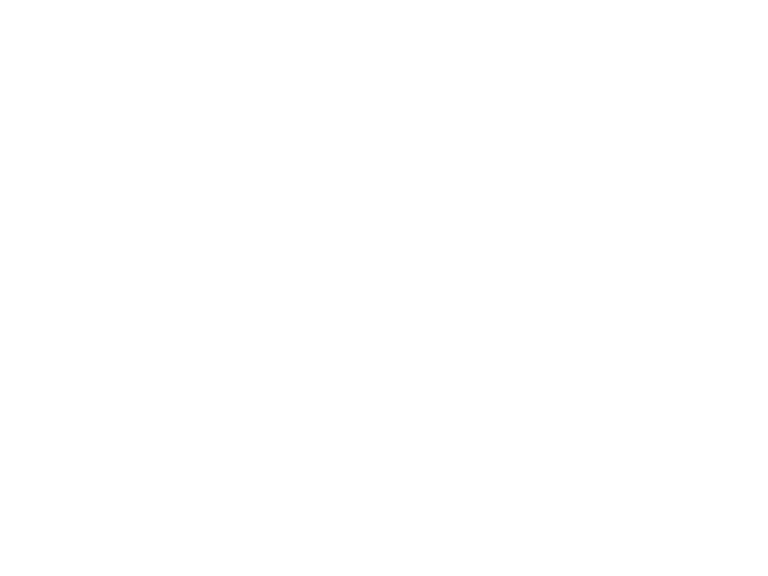

In [16]:
plotSamples(features[:,:,sample,:]*255, False, False, False, False)

In [17]:
I, kmeans, stripeColour =  faissCluster(features, stripeFrac, stripe_startNo, it, False) # perform faiss clustering looking for stripe

clustering with 1

Sampling a subset of 256 / 190288800 for training
Clustering 256 points in 3D to 1 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.45 s
Cluster Min was 1.0 s, search 0.00 s): objective=6.38782 imbalance=1.000 nsplit=0       

clustering with 2


Sampling a subset of 512 / 190288800 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.45 s
Cluster Min was 0.08398339786682138s): objective=2.76109 imbalance=1.654 nsplit=0       



In [18]:
## use cosine distance to find cluster closest to orange
stripeColour = get_colour_cosine(kmeans, [255,169,0])

<IPython.core.display.Javascript object>


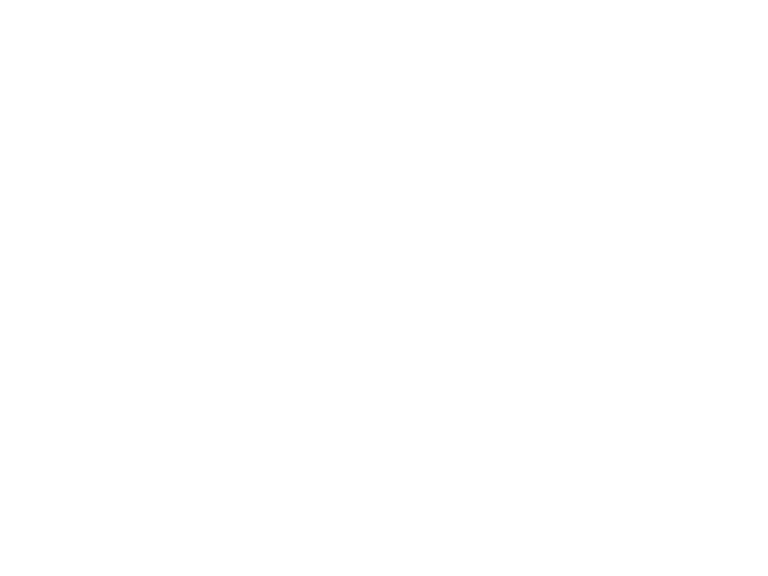

In [19]:
imgArr = clus2Image(I, kmeans.centroids[:,0:3], {stripeColour[0]: [0,1,0]}, False) # check array shapes here??
imgArr = np.reshape(imgArr, orig_shape)
plotSamples(imgArr[:,:,sample,:]*255, False, False, False, False)

In [20]:
## use know stripe locations to normalise colour accross data set using mean translate and then rgb chormisation
features, noStripe = norm_to_target(I,pixcels,stripeColour, True)

used Last pic mean [112.0, 48.0, 30.0] for image number 267
used Last pic mean [166.0, 74.0, 46.0] for image number 683
used Last pic mean [20.0, 12.0, 6.0] for image number 994
used Last pic mean [150.0, 66.0, 38.0] for image number 1015
used Last pic mean [62.0, 34.0, 22.0] for image number 1303
used Last pic mean [96.0, 46.0, 26.0] for image number 1426
used Last pic mean [112.0, 50.0, 30.0] for image number 1454
used Last pic mean [130.0, 54.0, 36.0] for image number 1468
used Last pic mean [102.0, 52.0, 34.0] for image number 1533
used Last pic mean [192.0, 102.0, 70.0] for image number 1662
used Last pic mean [210.0, 106.0, 74.0] for image number 1754
used Last pic mean [252.0, 120.0, 76.0] for image number 1937
used Last pic mean [156.0, 82.0, 58.0] for image number 1943
used Last pic mean [86.0, 44.0, 30.0] for image number 2108
used Last pic mean [244.0, 100.0, 60.0] for image number 2343
used Last pic mean [198.0, 90.0, 62.0] for image number 2563
used Last pic mean [146.0, 7

<IPython.core.display.Javascript object>


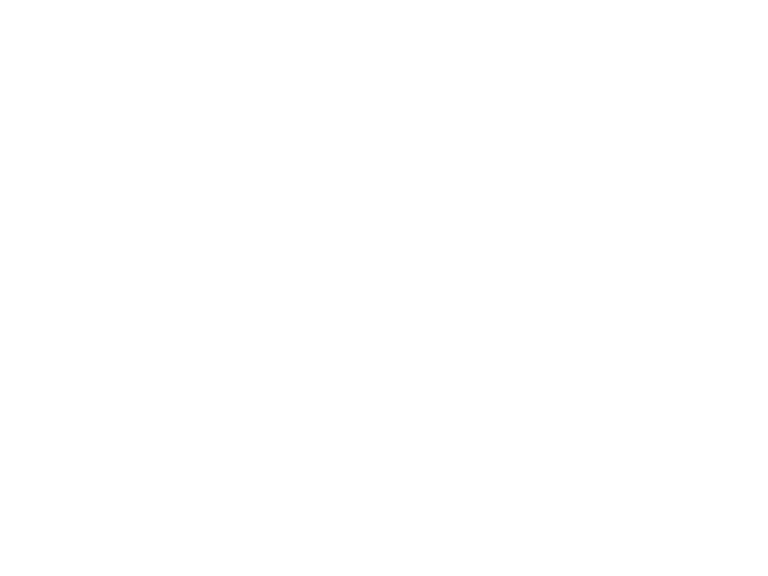

In [21]:
plotSamples(features[:,:,sample,:]*255, True, False, False, False)

In [22]:
## recluster using improved features
I, kmeans, stripeColour =  faissCluster(features, stripeFrac, 1, it, noStripe/l) # rerun kmeans on normalised pixcels

clustering with 1


Sampling a subset of 256 / 190288800 for training
Clustering 256 points in 3D to 1 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.44 s
Cluster Min was 1.0 s, search 0.00 s): objective=9.9941 imbalance=1.000 nsplit=0        

clustering with 2


Sampling a subset of 512 / 190288800 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.44 s
Cluster Min was 0.1364148494288681 s): objective=10.1731 imbalance=1.343 nsplit=0       

clustering with 3


Sampling a subset of 768 / 190288800 for training
Clustering 768 points in 3D to 3 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.45 s
Cluster Min was 0.07162104653558171s): objective=9.19895 imbalance=2.008 nsplit=0       



In [23]:
## check the cluster found as the stripe is closest in colour to what was expected
stripeColour_cosine = get_colour_cosine(kmeans, [255,169,0]) # find stripe colour using cosine distance
if stripeColour_cosine != stripeColour:
    print("Error, the cluster found for stripes is inconsitent")

<IPython.core.display.Javascript object>


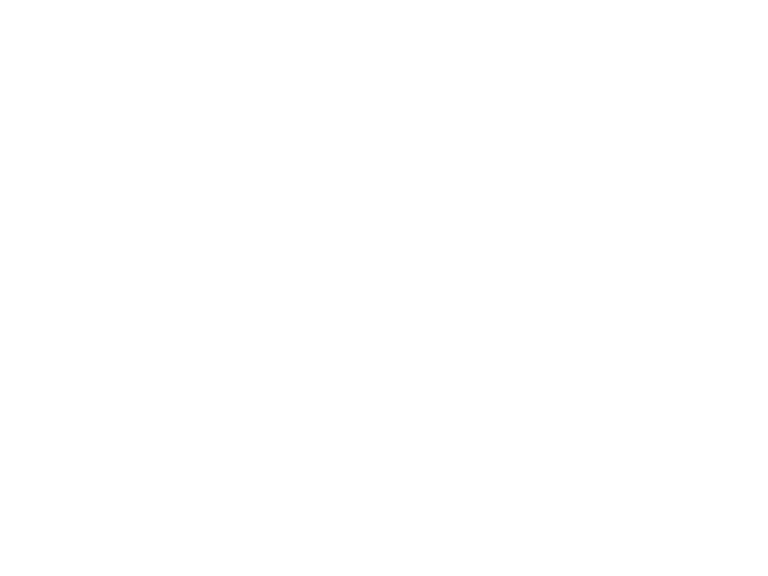

In [24]:
## plot final stripe clusters
imgArr = clus2Image(I, kmeans.centroids[:,0:3], {stripeColour[0]: [0,255,0]}, False)
imgArr = np.reshape(imgArr, orig_shape)
plotSamples(imgArr[:,:,sample,:], False, False, False, False)

In [25]:
## Get the stripe coordinates
stripe_coords = np.array(np.where(np.reshape(I, (h,w,l)) == stripeColour))

<IPython.core.display.Javascript object>


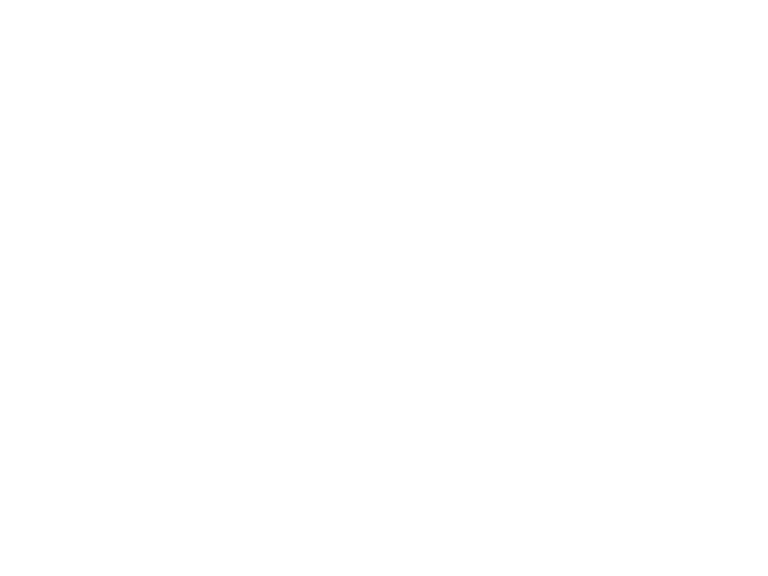

The min projected y value before cleaning is -90.88454655037829
The max projected y value before cleaning is 13.640593261983039
The min projected y value after cleaning is -75.8073511343066
The max projected y value after cleaning is -36.58316887077219


<IPython.core.display.Javascript object>


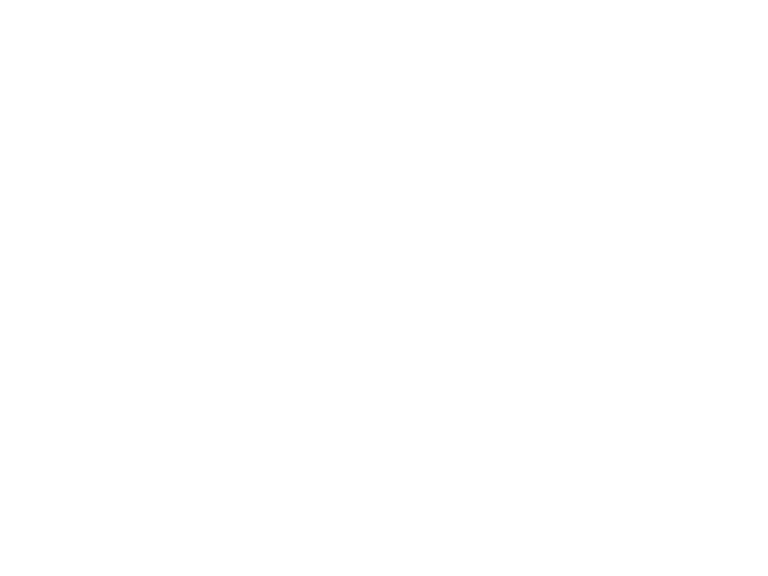

The min projected y value before cleaning is -199.7776527750384
The max projected y value before cleaning is -2.6015564468730537
The min projected y value after cleaning is -199.7776527750384
The max projected y value after cleaning is -64.84367737998225


<IPython.core.display.Javascript object>


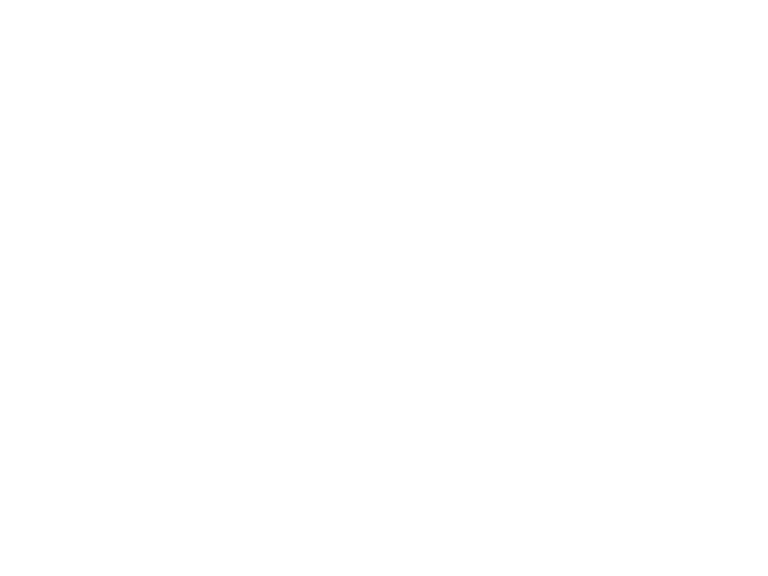

The min projected y value before cleaning is -82.53018019164386
The max projected y value before cleaning is -39.58163455188586
The min projected y value after cleaning is -80.57246216551594
The max projected y value after cleaning is -42.601719936450465


<IPython.core.display.Javascript object>


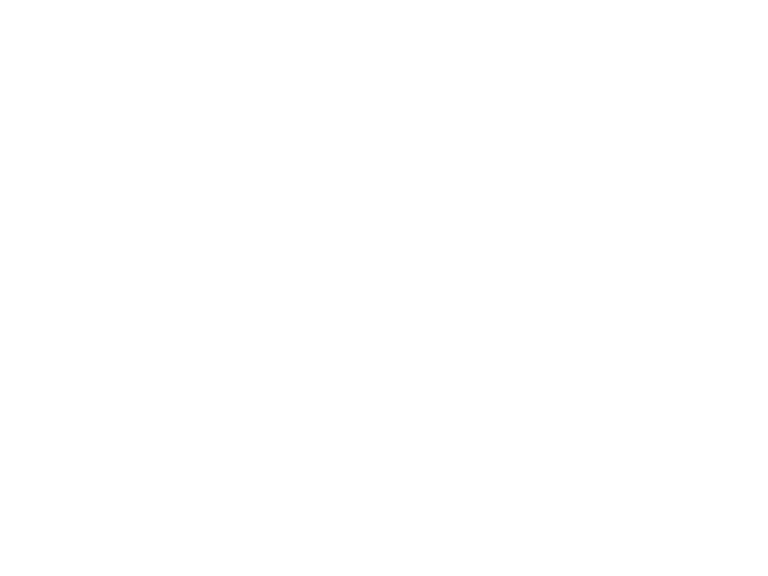

The min projected y value before cleaning is -196.90066908337886
The max projected y value before cleaning is -62.42636521449487
The min projected y value after cleaning is -196.90066908337886
The max projected y value after cleaning is -64.18238397954663
Stripe is roated 1.605485854057729 degrees


In [26]:
## use PCA to find the long edge of the stripe and project coordinates onto this axis
stripe_coords = np.array(np.where(np.reshape(I, (h,w,l)) == stripeColour)) # get stripe locations from reshaped labels array
Vh, stripe_coords_clean = find_rotation(stripe_coords)

In [27]:
imgNo, start_list, stop_list, length_list, prob_list, start_grad, stop_grad, stripeLength = cluster_length(stripe_coords_clean, Vh)

calculating cluster length for image #10271of10272


In [28]:
stripeStats_df = pd.DataFrame({'image': imgNo, 
                               'start': start_list, 
                               'stop': stop_list, 'length': length_list, 
                               'probability': prob_list, 
                               'startGrad': start_grad, 
                               'stopGrad': stop_grad})

In [29]:
stripeStats_df = getMiddle(stripeStats_df, stripeLength, "stripe")

In [30]:
## now recluster looking for dots
I, kmeans, dotColour =  faissCluster(features, dotFrac, stripe_startNo, it, noStripe/l)

clustering with 1


Sampling a subset of 256 / 190288800 for training
Clustering 256 points in 3D to 1 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.43 s
Cluster Min was 1.0 s, search 0.00 s): objective=9.9941 imbalance=1.000 nsplit=0        

clustering with 2


Sampling a subset of 512 / 190288800 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.44 s
Cluster Min was 0.1364148494288681 s): objective=10.1731 imbalance=1.343 nsplit=0       

clustering with 3


Sampling a subset of 768 / 190288800 for training
Clustering 768 points in 3D to 3 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.44 s
Cluster Min was 0.07162104653558171s): objective=9.19895 imbalance=2.008 nsplit=0       

clustering with 4


Sampling a subset of 1024 / 190288800 for training
Clustering 1024 points in 3D to 4 clusters, redo 1 times, 10 iterations
  Preprocessing in 3.45 s
Cluster Min was 0.06126303807686002s): objective=7.63539 imb

In [31]:
## check the cluster found as dot colour is the closest to the expected colour
dotColour_cosine = get_colour_cosine(kmeans, [0,256,0]) # find stripe colour using cosine distance
if dotColour_cosine != dotColour:
    print("Error, the cluster found for dots is inconsitent")

<IPython.core.display.Javascript object>


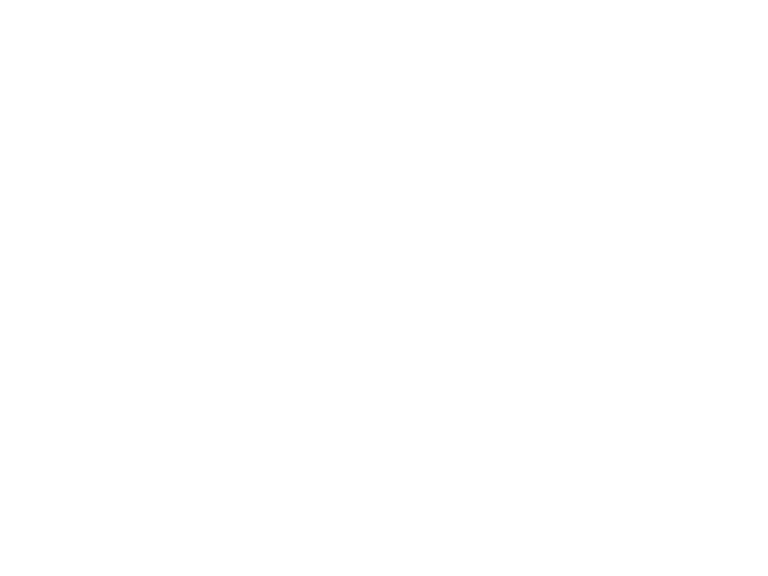

In [32]:
imgArr = clus2Image(I, kmeans.centroids[:,0:3], {dotColour[0]: [0,255,0]}, False)
imgArr = np.reshape(imgArr, orig_shape)
plotSamples(imgArr[:,:,sample,:], False, False, False, False)

<IPython.core.display.Javascript object>


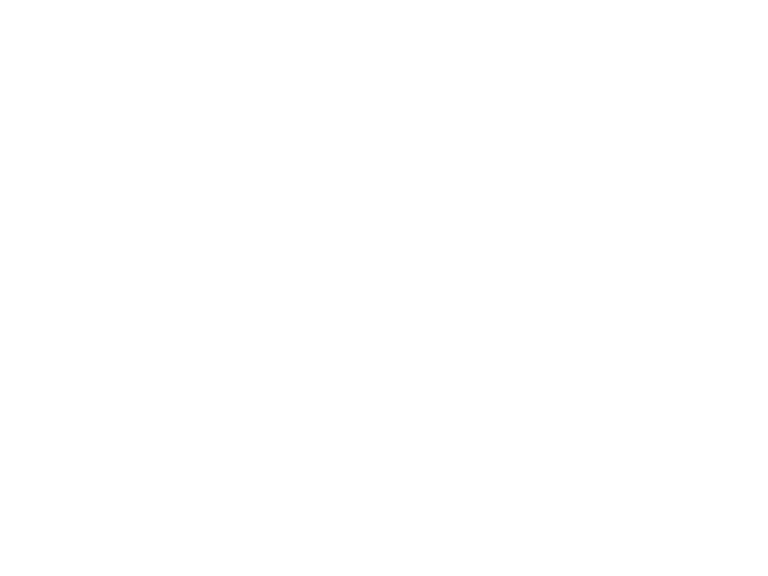

The min projected y value before cleaning is -12.012237691511265
The max projected y value before cleaning is 91.09520712003224
The min projected y value after cleaning is -4.220725576079371
The max projected y value after cleaning is 34.011441675619395


<IPython.core.display.Javascript object>


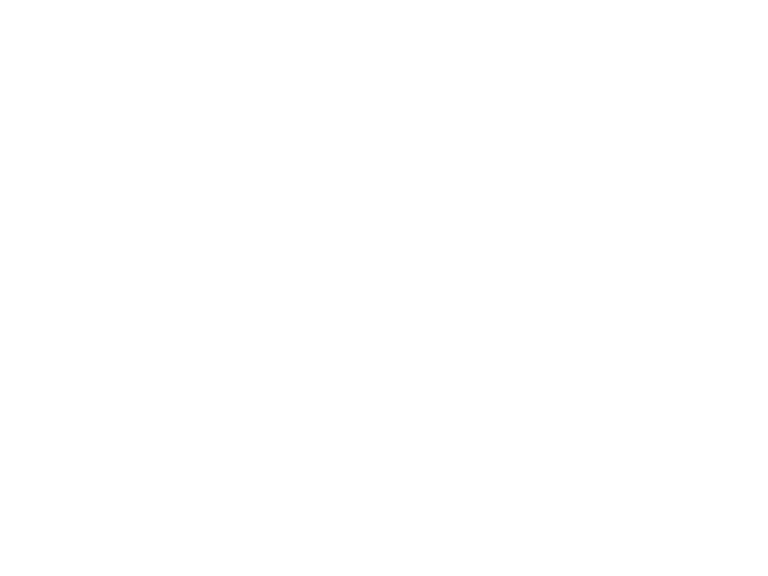

The min projected y value before cleaning is 0.0
The max projected y value before cleaning is 195.98066402381838
The min projected y value after cleaning is 0.0
The max projected y value after cleaning is 145.70509185647632


<IPython.core.display.Javascript object>


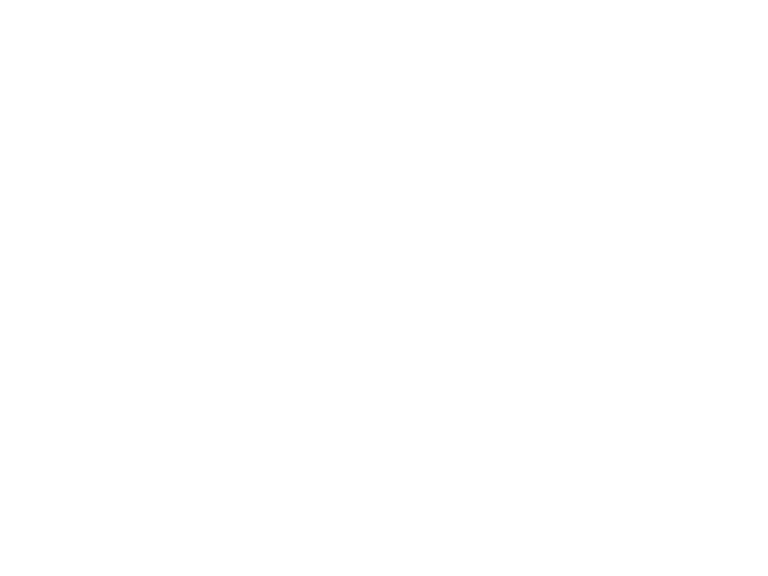

The min projected y value before cleaning is -1.8729710617215898
The max projected y value before cleaning is 34.160371802814524
The min projected y value after cleaning is -1.8729710617215898
The max projected y value after cleaning is 34.160371802814524


<IPython.core.display.Javascript object>


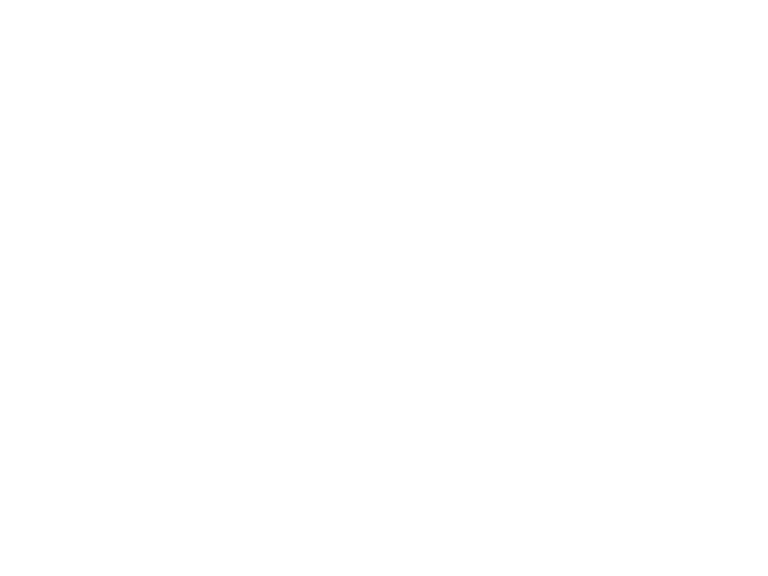

The min projected y value before cleaning is 0.0
The max projected y value before cleaning is 145.60000811791016
The min projected y value after cleaning is 0.0
The max projected y value after cleaning is 145.60000811791016
Stripe is roated 1.5133383003861443 degrees


In [33]:
dot_coords = np.array(np.where(np.reshape(I, (h,w,l)) == dotColour)) # get stripe locations from reshaped labels array
Vdot, dot_coords_clean = find_rotation(dot_coords)

In [34]:
imgNo, start_list, stop_list, length_list, prob_list, start_grad, stop_grad, dotLength = cluster_length(dot_coords_clean , Vh)

calculating cluster length for image #10271of10272


In [35]:
dotStats_df = pd.DataFrame({'image': imgNo, 
                               'start': start_list, 
                               'stop': stop_list, 'length': length_list, 
                               'probability': prob_list, 
                               'startGrad': start_grad, 
                               'stopGrad': stop_grad})

In [36]:
dotStats_df = getMiddle(dotStats_df, dotLength, "dot")

In [37]:
stats_df = pd.merge(stripeStats_df, dotStats_df, on = 'image')
        

In [38]:
measure = stats_df['stripe'] - stats_df['dot']


In [98]:
dataOut = pd.DataFrame({'time':timeStamp, 'measure':measure})


In [99]:
dataOut = dataOut.sort_values('time')

In [100]:
dataOut


,time,measure
9676,2022:04:23 13:28:18,93.0
1140,2022:04:23 13:28:19,92.5
7686,2022:04:23 13:28:20,93.0
7952,2022:04:23 13:28:21,93.0
5984,2022:04:23 13:28:22,93.0
...,...,...
8079,2022:04:23 16:19:25,50.0
6857,2022:04:23 16:19:26,51.0
3530,2022:04:23 16:19:27,53.0
5867,2022:04:23 16:19:28,53.0


<IPython.core.display.Javascript object>


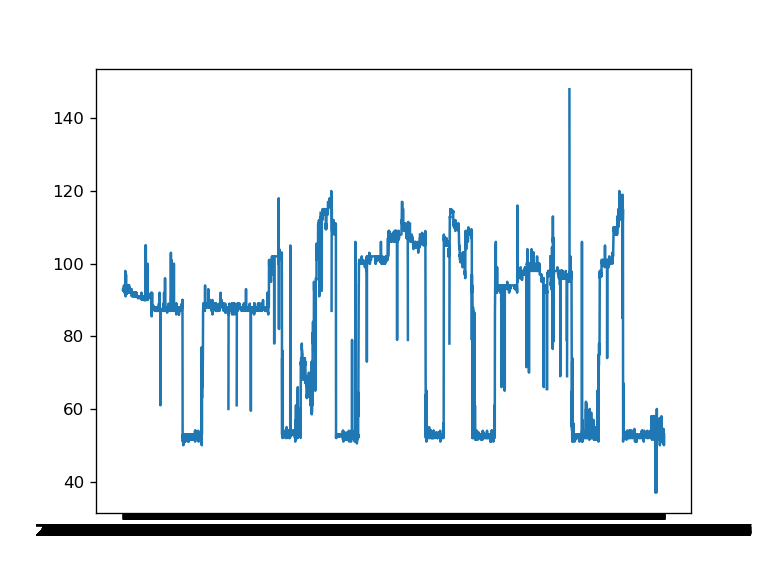

In [101]:
plt.close()
plt.plot(dataOut.time,dataOut.measure)

In [102]:
dataOut.dropna(axis=0, how='any', inplace=True)

In [103]:
x = np.array(list(dataOut.measure))


In [104]:
xf = fft(x)

In [105]:
y =  np.array(list(dataOut.time))

In [106]:
yf = fftfreq(len(y),1)

In [107]:
yf

array([ 0.00000000e+00,  9.83961429e-05,  1.96792286e-04, ...,
       -2.95188429e-04, -1.96792286e-04, -9.83961429e-05])

<IPython.core.display.Javascript object>


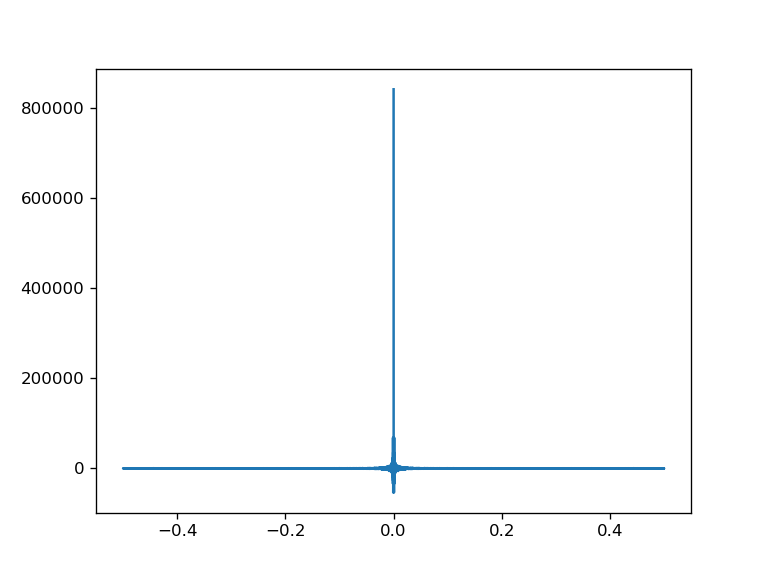

/home/veering/anaconda3/envs/visualStringpot/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [108]:
plt.close()
plt.plot(yf,xf)

In [109]:
xf_abs = np.abs(xf)

In [110]:
indicies = xf_abs>1000

In [111]:
xf_clean = indicies * xf

<IPython.core.display.Javascript object>


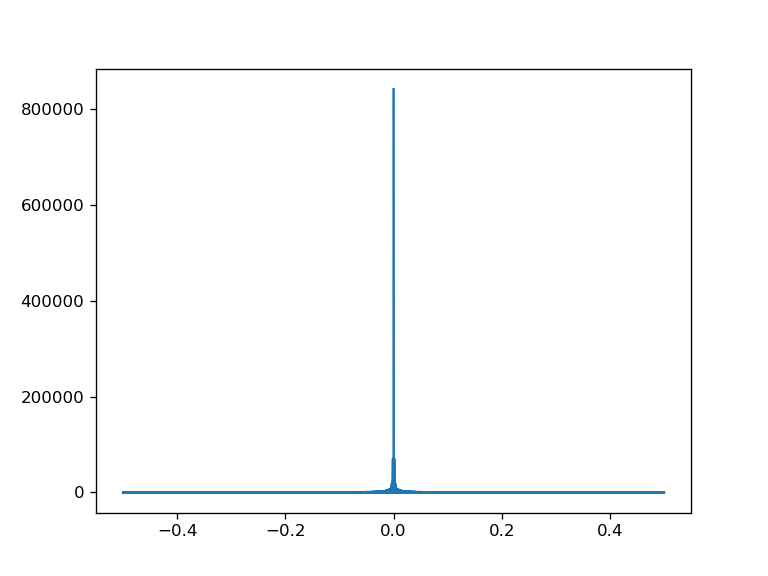

In [112]:
plt.close()
plt.plot(yf, np.abs(xf_clean))

In [113]:
new_f_clean = ifft(xf_clean)

<IPython.core.display.Javascript object>


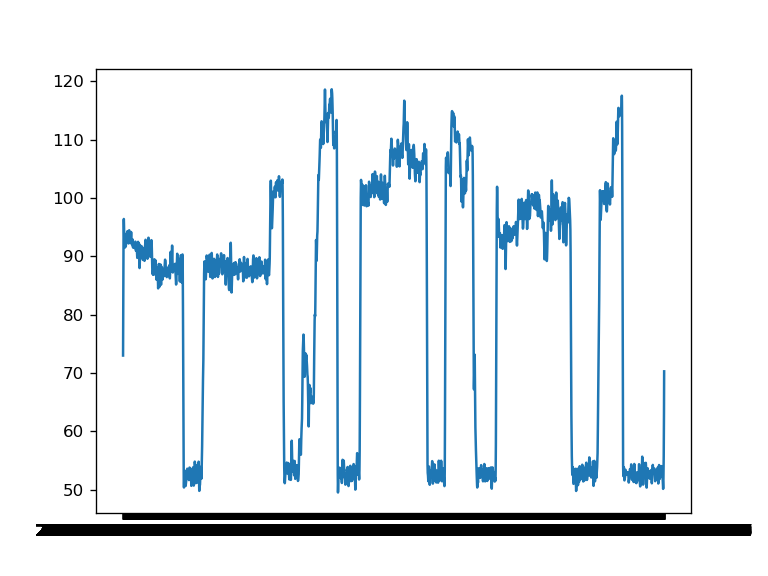

/home/veering/anaconda3/envs/visualStringpot/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [114]:
plt.close()
plt.plot(y, new_f_clean)

In [115]:
avg = pd.Series(new_f_clean)

In [116]:
avg = avg.rolling(5).mean()

/home/veering/anaconda3/envs/visualStringpot/lib/python3.9/site-packages/pandas/core/window/rolling.py:348: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


<IPython.core.display.Javascript object>


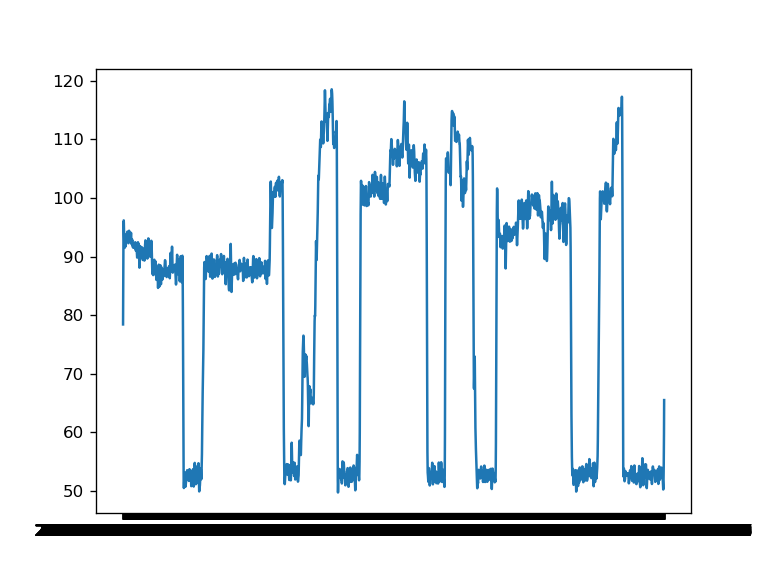

In [117]:
plt.close()
plt.plot(y, avg)

In [ ]:
print(stripeColour_cosine)
print(stripeColour)
stripeColour=stripeColour_cosine

In [ ]:
## define known geometry
knownLength = -87 # known length of the stripe, negative if measure should get larger when dot is closer to stripe
offset = -127.5 # known zero offset

In [ ]:

stripe_loc = np.array(
    np.where(np.reshape(I, (h, w, l)) == stripeColour))  # get stripe locations from reshaped labels array

perpClean_min = 25
perpClean_max = 75
rotClean_min = 26
rotClean_max = 75
stripe_perp = stripe_loc[0:2, :].T @ Vh[:, 1]  # rotate stripe onto second principle component of stripe to clean
stripe_perp = cleanIQR(perpClean_max, perpClean_min, stripe_perp, False, False)  # remove outliers from stripe rot
stripe_perp = np.vstack((stripe_perp, stripe_perp, stripe_perp))
stripe_loc = np.reshape(stripe_loc[stripe_perp], (3, -1))
stripe_rot = stripe_loc[0:2, :].T @ Vh[:, 0]  # rotate stripe onto first principle component
stripe_rot = cleanIQR(rotClean_max, rotClean_min, stripe_rot, False, False)
stripe_rot = np.vstack((stripe_rot, stripe_rot, stripe_rot))
stripe_loc = np.reshape(stripe_loc[stripe_rot], (3, -1))

pca = PCA(2)
pca.fit(stripe_loc[0:2, :].T)
Vh = pca.components_
stripe_rot = stripe_loc[0:2, :].T @ Vh[:, 0]  # rotate stripe onto first principle component
stripeMedian = np.median(stripe_rot)  # find median of the stripe
stripe_len = (
    abs(abs(np.min(stripe_rot)) - abs(np.max(stripe_rot))))  # finds the abs range of the stripe (known length)

In [ ]:

## plot sample images with the principle componets on it for assesment
stripe_perp = stripe_loc[0:2, :].T @ Vh[:, 1]  # rotate stripe onto second principle component of stripe to clean
stripe_perp = cleanIQR(perpClean_max, perpClean_min, stripe_perp, True, False)  # remove outliers from stripe rot

stripePlot = [stripe_rot.min(),stripe_rot.max(), np.median(stripe_perp), stripe_perp.min(),stripe_perp.max(), stripeMedian]
plt.close()
check = clus2Image(I, kmeans.centroids, {int(0): [0,255,0]}, True) # get image array with stripe clusters changed to green
check = np.reshape(check, orig_shape) # reshape for plotting
check = check[:,:,1,:] # reduce to just sample images
check = Image.fromarray(check.astype('uint8'))

angle = 90 - math.degrees(math.acos(Vh[1,1]))
check = np.asarray(check.rotate(angle))
plt.imshow(check[:, :, :].astype('uint8'))
plt.plot([np.array(([stripePlot[0],0])@ np.linalg.inv(Vh)[1])*1,
          np.array([stripePlot[1],0]) @ np.linalg.inv(Vh)[1]*1],
         [np.array([0,stripePlot[2]]) @ np.linalg.inv(Vh)[0]*1,
          np.array([0,stripePlot[2]]) @ np.linalg.inv(Vh)[0]*1], linewidth = 3)

plt.plot([np.array([stripePlot[5],0]) @ np.linalg.inv(Vh)[1]*1,
          np.array([stripePlot[5],0]) @ np.linalg.inv(Vh)[1]*1],
         [np.array([0,stripePlot[3]]) @ np.linalg.inv(Vh)[0]*1,
          np.array([0,stripePlot[4]]) @ np.linalg.inv(Vh)[0]*1], linewidth = 3)

## Delete variables not required for dot search to free up ram

In [ ]:
dot_startNo = len(kmeans.centroids) + stepAfterStripeCluss  # # of clusters to start finding the dot cluster
scale = knownLength / stripe_len  # calculate the pixcel to mm scale

In [ ]:

## add the positions projected onto the 2nd principal component to aid in finding dot cluster
#features = np.reshape(features, (w*h*l,d))
dot_search = addInd(w, h, l, imgArray, True, Vh)  # add indices

In [ ]:
scaler = StandardScaler()
dot_search = scaler.fit_transform(dot_search)
## Cluster to find dots

In [ ]:
dot_search

In [ ]:
I, kmeans, dotColour = faissCluster(dot_search, dotFrac, 3, it)  # perform faiss clustering looking for dot

In [ ]:
dotColour[0][0]

In [ ]:


imgArr = clus2Image(I, kmeans.centroids[:,0:3], {dotColour[0][0]: [255,125,0]}, False)
imgArr = np.reshape(imgArr, orig_shape)

In [ ]:
plotSamples(imgArr[:,:,sample,:], False, False, False, False)

In [ ]:
imgArray = norm_to_target(I,pixcels,dotColour[0][0])

In [ ]:
plotSamples(imgArray[:,:,sample,:]*255, False, False, False, False)

In [ ]:
dot_search = addInd(w, h, l, np.reshape(imgArray,(w*h*l,d)), True, Vh)  # add indices
scaler = StandardScaler()
dot_search = scaler.fit_transform(dot_search)
I, kmeans, dotColour = faissCluster(np.reshape(imgArray,(w*h*l,d)), dotFrac, 3, it)  # perform faiss clustering looking for dot

In [ ]:
dotColour[0]


In [ ]:
kmeans.centroids*255

In [ ]:
imgArr = clus2Image(I, kmeans.centroids[:,0:3], {dotColour[0][0]: [0,255,0]}, False)
imgArr = np.reshape(imgArr, orig_shape)
plotSamples(imgArr[:,:,[1950,2950,3950,4950],:], False, False, False, False)

In [ ]:
colours.shape

In [ ]:
check = colours[labels]

In [ ]:
check[0,:,:]

In [ ]:
kmeans.centroids[:,0:3]

In [ ]:

check = clus2Image(I, kmeans.centroids[:, 0:3],
                   {dotColour[0][0]: [0, 255, 0]}, True)  # get image array with dot clusters changed to green
check = np.reshape(check[:, 0:2], orig_shape)  # reshape for plotting
check = check[:, :, sample, :]  # reduce to just sample images
plotSamples(check, True, False, False, False)  # plot sample images to check clustering

In [ ]:
check = check[:, :, sample, :]  # reduce to just sample images
plotSamples(check, True, False, False, False)

In [ ]:
I = np.reshape(I, (h*w*l,1))
dot_loc = np.array(
    np.where(np.reshape(I, (h, w, l)) == dotColour))  # get dot locations x,y,l from reshaped labels array
dot_perp = dot_loc[0:2, :].T @ Vh[:, 1]  # rotate dot x and y onto second principle component of stripe to clean
perp_keep = cleanIQR(85, 15, dot_perp, False,
                     True)  # get true fals of values to keep in dot_loc based on outliers from dot on the 2nd principle component
## clean dot loc by perp keep
perp_keep = np.reshape(perp_keep, (1, -1))  # make 2d array with 1 row
perp_keep = np.vstack(
    (perp_keep, perp_keep, perp_keep))  # stack logical ontop of itself 3 times to match shape of dot_loc
dot_loc = np.reshape(dot_loc[perp_keep], (3, -1))  # subset dot_loc using perp_keep and return to origninal shape
dot_rot = dot_loc[0:2, :].T @ Vh[:, 0]  # rotate the remianing dost onto first principle component of stripe
rot_keep = cleanIQR(90, 10, dot_rot, False, True)  # clean dots by IQR
rot_keep = np.reshape(rot_keep, (1, -1))  # reshape to make 2d array with 1 row
rot_keep = np.vstack((rot_keep, rot_keep, rot_keep))  # stack to match shape of dot_loc
dot_loc = np.reshape(dot_loc[rot_keep], (3, -1))  # subset using rot_keep and reshape to original shape
dot_rot = dot_loc[0:2, :].T @ Vh[:, 0]  # rotate remaining dots onto first principal component
dot_rot = np.vstack((dot_rot, dot_loc[2, :]))  # stack the image number and rotated values ontop of eachother
dotsDF = pd.DataFrame(np.transpose(dot_rot),
                      columns=['Dot', 'Pic'])  # change fron NP array to data frame for easy grouping
knownLength = -87  # known length of the stripe, negative if measure should get larger when dot is closer to stripe
offset = -127.5  # known zero offset
scale = knownLength / stripe_len  # calculate the pixcel to mm scale
dataOut = dotsDF.groupby('Pic').median()
dataOut
dataOut = dataOut.merge(dotsDF.groupby('Pic').count(), left_index=True, right_index=True)
dataOut = dataOut.merge(pd.DataFrame(file_list), left_index=True, right_index=True)
dataOut = dataOut.merge(pd.DataFrame(timeStamp), left_index=True, right_index=True)
dataOut = dataOut.rename(columns={'Dot_x': 'Dot', 'Dot_y': 'Count', '0_x': 'file', '0_y': 'timeStamp'})
dataOut = dataOut[dataOut['Count'] > 0.6 * dot_area]  # change back to 0.6
dataOut = dataOut[dataOut['Count'] < 1.4 * dot_area]  #change back to 1.4
dataOut['measure'] = ((abs(stripeMedian - dataOut.Dot) * scale) - offset) * 1.17
dataOut = dataOut.sort_values('timeStamp')
dataOut.to_csv(out_dir + 'vSp_gp+220507.csv')
print("dataOut saved in " + out_dir + 'vSp.csv\n\n')
print(str(dataOut.head()) + '\n\n')
print(dataOut.describe())

plt.close()
plt.plot(dataOut.timeStamp, dataOut.measure)

dataOut = dotsDF.groupby('Pic').median()
dataOut = dataOut.merge(dotsDF.groupby('Pic').count(), left_index=True, right_index=True)
dataOut = dataOut.merge(pd.DataFrame(file_list), left_index=True, right_index=True)
dataOut = dataOut.merge(pd.DataFrame(timeStamp), left_index=True, right_index=True)
dataOut = dataOut.rename(columns={'Dot_x': 'Dot', 'Dot_y': 'Count', '0_x': 'file', '0_y': 'timeStamp'})
dataOut.Count.max()